In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
data_name = 'qqp'

In [17]:
def moving_average(data, window_size):
    """Compute the moving average of a list or array."""
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

In [39]:
metric = 'sensitivity'
sensitivity_data = {
    'lstm': moving_average(
        np.mean(np.load(f'logs/{data_name}/lstm/default/'+metric+'.npy'), axis=1),
        window_size=1),
    'roberta': moving_average(
        np.mean(np.load(f'logs/{data_name}/roberta-scratch/default/'+metric+'.npy'), axis=1), 
        window_size=1),
    'roberta (relu)': moving_average(
        np.mean(np.load(f'logs/{data_name}/roberta-scratch_relu/default/'+metric+'.npy'), axis=1), 
        window_size=1)
}

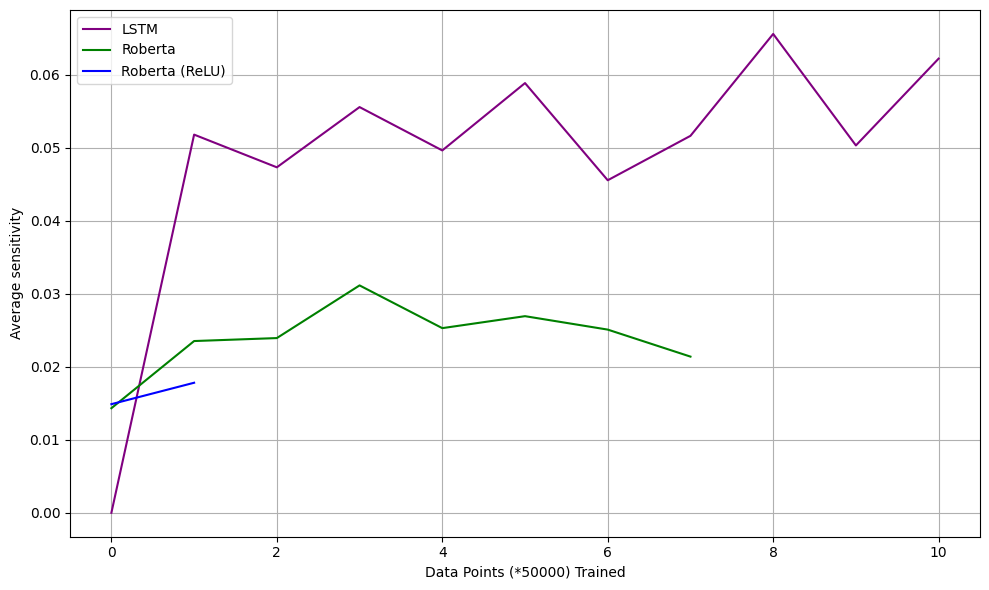

In [43]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10, 6))
ax.plot(sensitivity_data['lstm'], label='LSTM', color='purple')
ax.plot(sensitivity_data['roberta'], label='Roberta', color='green')
ax.plot(sensitivity_data['roberta (relu)'], label='Roberta (ReLU)', color='blue')
ax.set_xlabel('Data Points (*50000) Trained')
ax.set_ylabel(f'Average {metric}')
#plt.title('Change of Average Sensitivity with Data Points Trained')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
metric = 'validationacc'
validation_data = {
    'lstm': moving_average(
        np.load(f'logs/{data_name}/lstm/default/'+metric+'.npy'),
        window_size=1),
    'roberta': moving_average(
        np.load(f'logs/{data_name}/roberta-scratch/default/'+metric+'.npy'), 
        window_size=1),
    'roberta (relu)': moving_average(
        np.load(f'logs/{data_name}/roberta-scratch_relu/default/'+metric+'.npy'), 
        window_size=1)
}

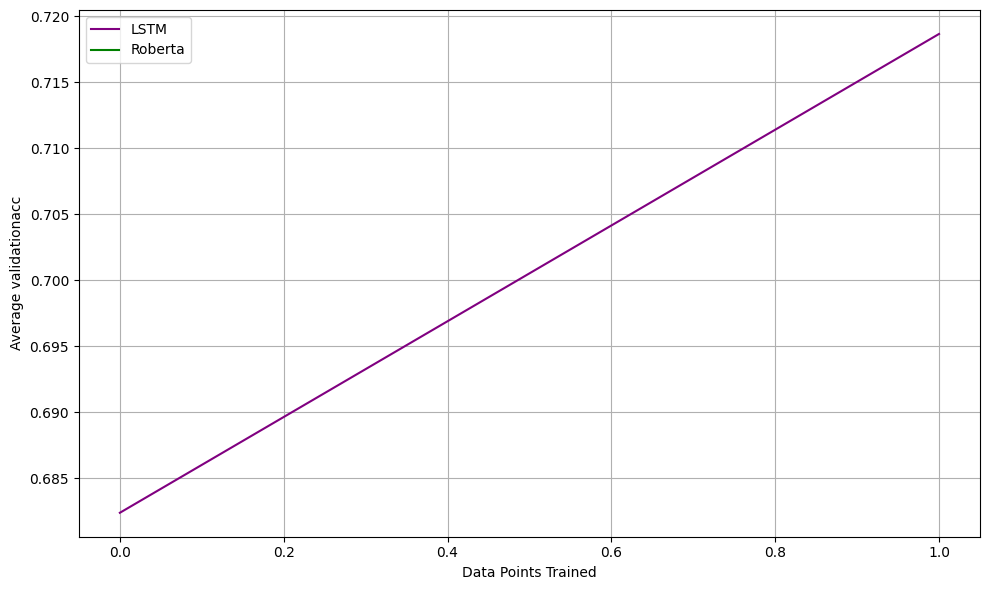

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(sensitivity_data['lstm'], label='LSTM', color='purple')
plt.plot(sensitivity_data['roberta'], label='Roberta', color='green')
plt.plot(sensitivity_data['roberta'], label='Roberta', color='green')
plt.xlabel('Data Points Trained')
plt.ylabel(f'Average {metric}')
#plt.title('Change of Average Sensitivity with Data Points Trained')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()